# MRS etalon line overlap
In this notebook we attempt to derive a wavelength solution for MRS band 1A based on the periodic pattern of the etalon line overlapping in the RAL FTS and the MIRI FM datasets.  

In [1]:
# load python modules
import funcs
import mrsobs
from distortionMaps import d2cMapping

import numpy as np
from datetime import date
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [2]:
# Define paths to data
workDir  = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir   = workDir+'cdp_data/CDP8/'
lvl2path = workDir+'/FM_data/LVL2/'
d2cMapDir = workDir+'notebooks/distortionMaps/'
MRSWaveCalDir = workDir+'MRSWaveCal/'

# MRS spectral band
bands = ['1A','1B','1C','2A','2B','2C','3A','3B','3C','4A','4B','4C']

# MRS etalons
etalons = ['ET1A','ET1B','ET2A','ET2B']

In [3]:
# select bands for analysis
ET1,ET2 = 'ET1A','ET1B'
band1,band2 = '1C','2A'

ET1,ET2 = 'ET1B','ET2A'
band1,band2 = '3A','3B'
start_band  = band1
target_band = band2

if target_band[0] == '1':
    refslice = 11
if target_band[0] == '2':
    refslice = 9
elif target_band[0] == '3':
    refslice = 8
elif target_band[0] == '4':
    refslice = 6
alpha_pos=0.

d2c_fileversion = '8B.05.00'

In [4]:
# load data
etalon_data_fm = {}
for etalon in [ET1,ET2]:
    etalon_data_fm[etalon] = {}
    for band in [band1,band2]:
        sci_img,bkg_img  = mrsobs.FM_MTS_800K_BB_extended_source_through_etalon(lvl2path,band,etalon=etalon)
        etalon_data_fm[etalon][band] = sci_img-bkg_img

In [5]:
# plt.figure(figsize=(13,6))
# plt.plot(etalon_data_fm['ET1B']['3A'][ypos,xpos['3A']])
# plt.plot(etalon_data_fm['ET2A']['3A'][ypos,xpos['3A']])
# plt.xlim(0,1024)
# plt.ylim(0)
# plt.tight_layout()

<IPython.core.display.Javascript object>


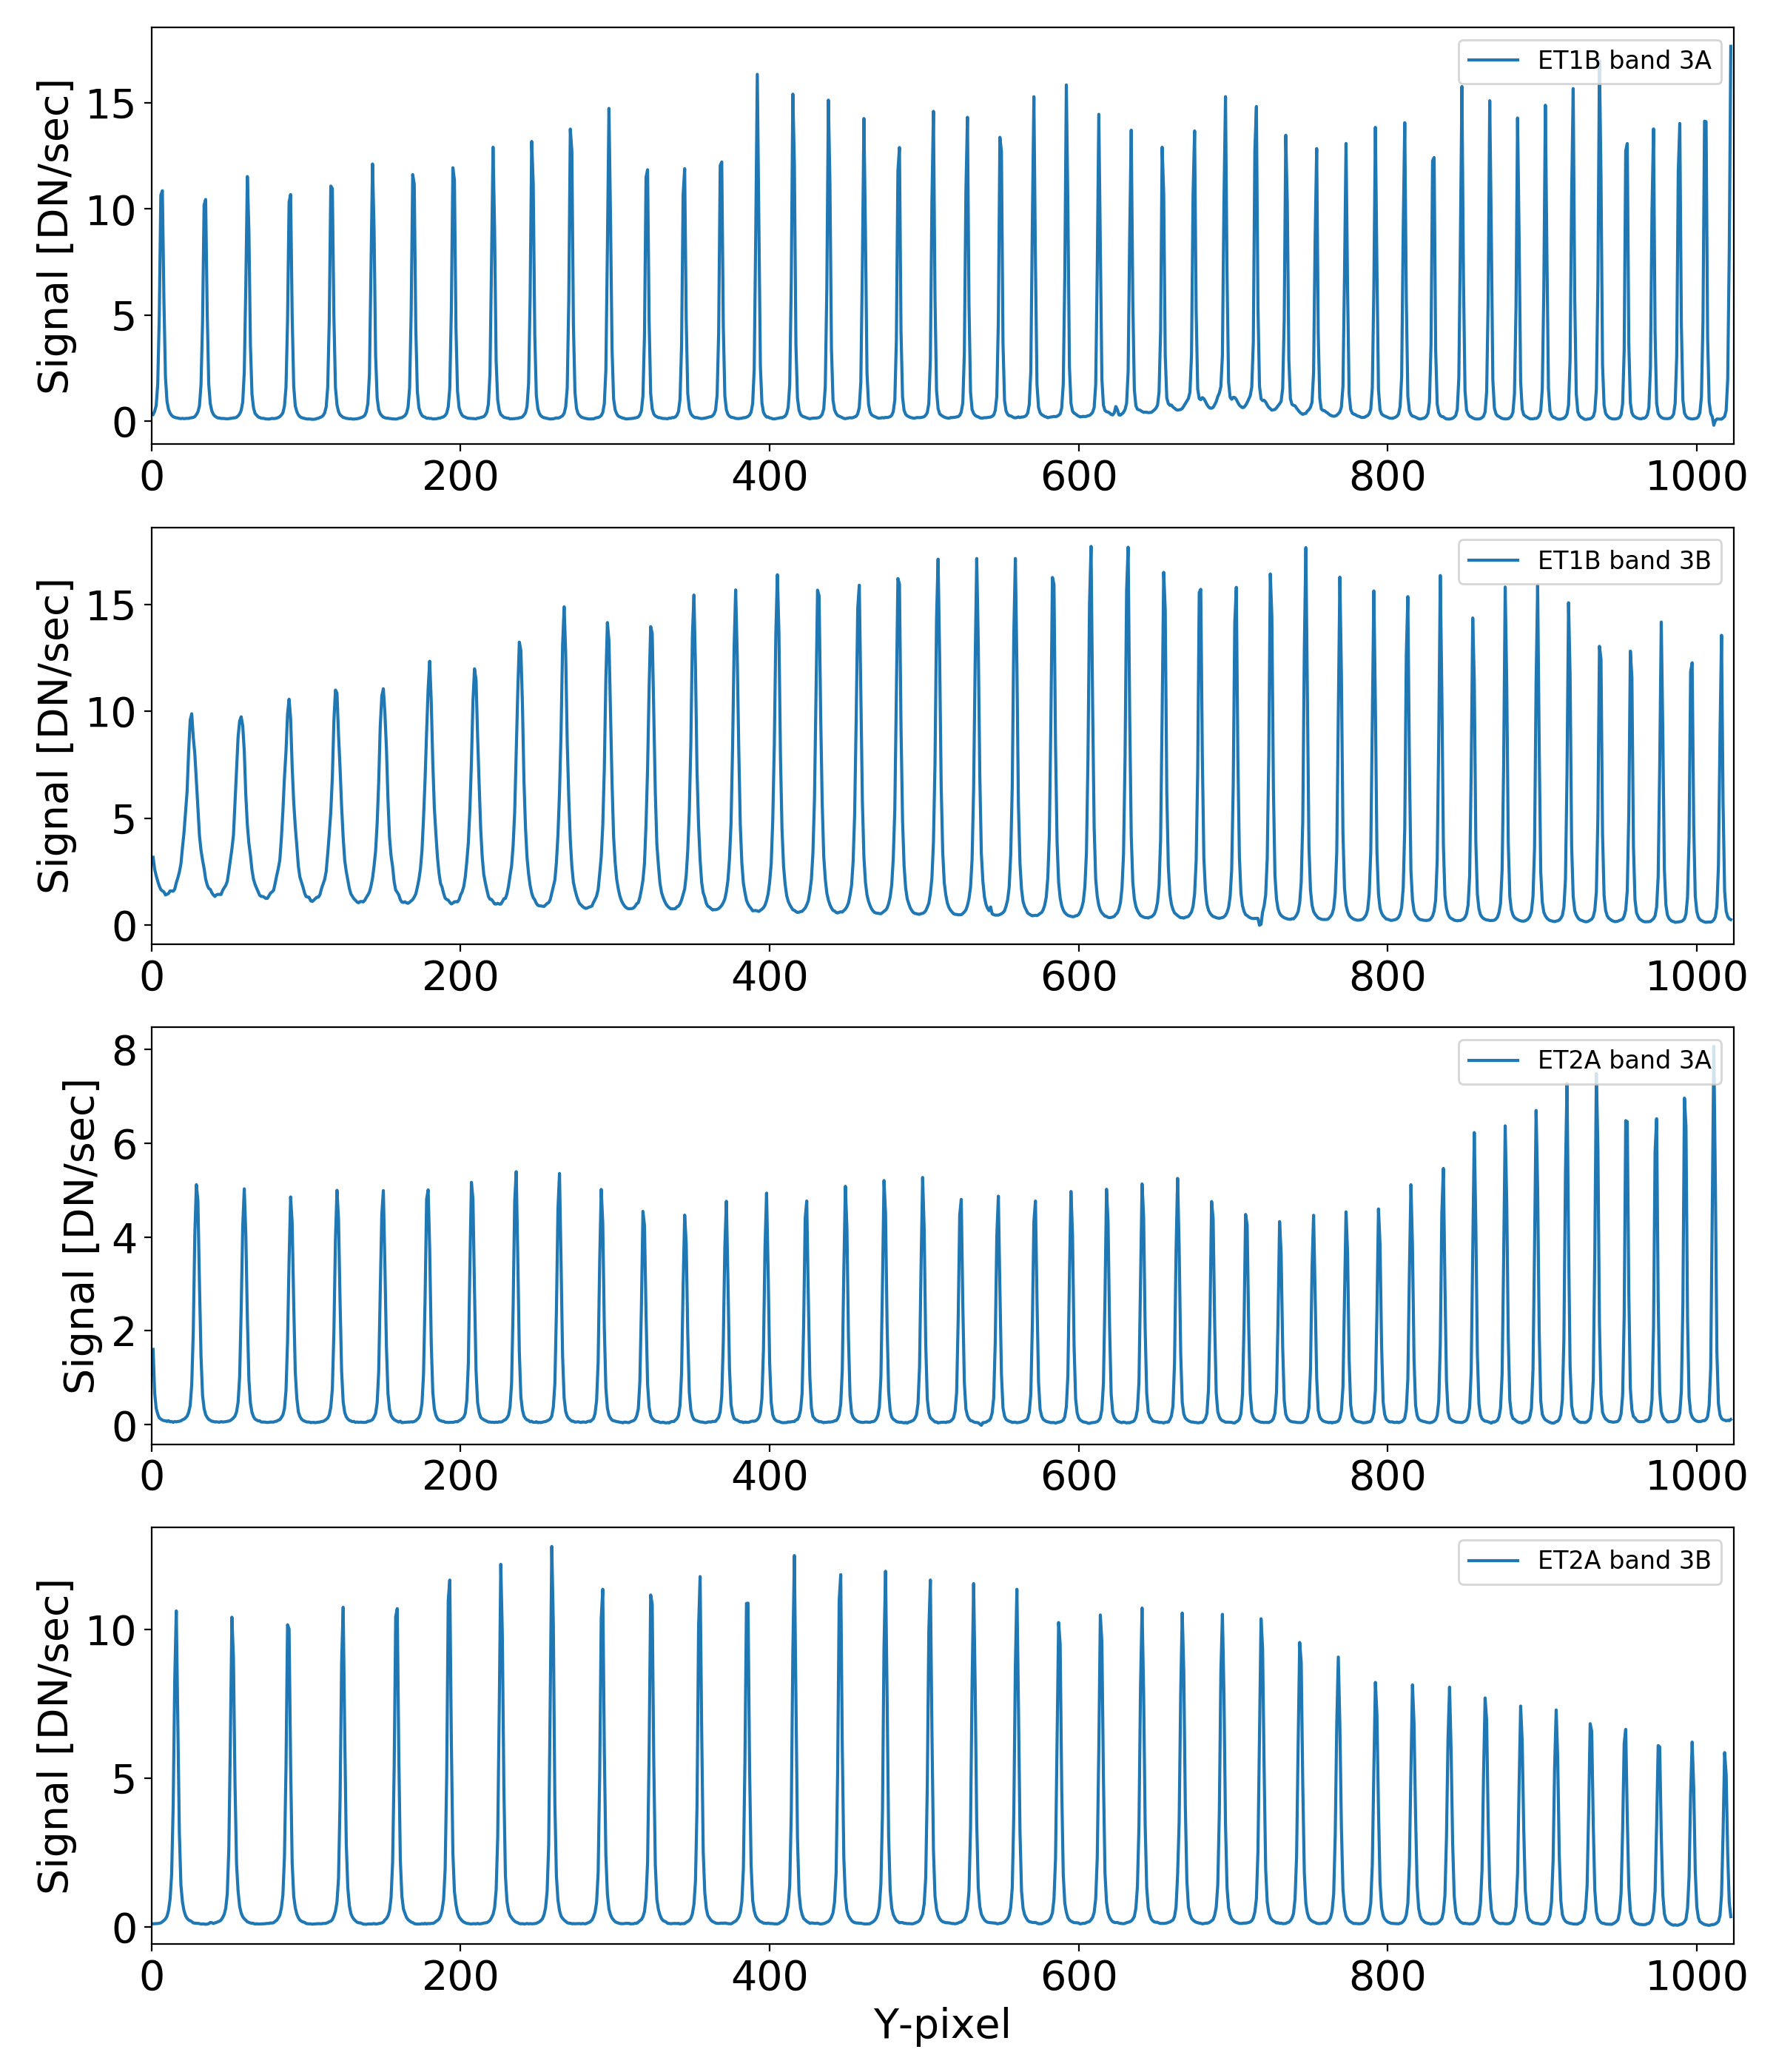

In [6]:
# plot data
xpos = {}
for band in [band1,band2]:
    d2cMaps = funcs.load_obj('d2cMaps_band{}_tr80pc'.format(band),path=d2cMapDir)
    ypos,xpos[band] = funcs.detpixel_trace(band,d2cMaps,sliceID=refslice,alpha_pos=0.)

fig,axs = plt.subplots(4,1,figsize=(12,14))
axs[0].plot(etalon_data_fm[ET1][band1][ypos,xpos[band1]],label='{} band {}'.format(ET1,band1))
axs[1].plot(etalon_data_fm[ET1][band2][ypos,xpos[band2]],label='{} band {}'.format(ET1,band2))
axs[2].plot(etalon_data_fm[ET2][band1][ypos,xpos[band1]],label='{} band {}'.format(ET2,band1))
axs[3].plot(etalon_data_fm[ET2][band2][ypos,xpos[band2]],label='{} band {}'.format(ET2,band2))
axs[3].set_xlabel('Y-pixel')
for plot in range(4):
    axs[plot].set_xlim(0,1024)
    axs[plot].set_ylabel('Signal [DN/sec]')
    axs[plot].legend(loc='upper right',fontsize=12)
plt.tight_layout()

In [7]:
thres_e1a,min_dist_e1a,sigma0_e1a,thres_e1b,min_dist_e1b,sigma0_e1b,thres_e2a,min_dist_e2a,sigma0_e2a,thres_e2b,min_dist_e2b,sigma0_e2b = [{} for i in range(12)]
for band in [band1,band2]:
    ignore,ignore,thres_e1a[band],min_dist_e1a[band],sigma0_e1a[band],thres_e1b[band],min_dist_e1b[band],sigma0_e1b[band],thres_e2a[band],min_dist_e2a[band],sigma0_e2a[band],thres_e2b[band],min_dist_e2b[band],sigma0_e2b[band] = funcs.etalon_line_params(band)

<IPython.core.display.Javascript object>


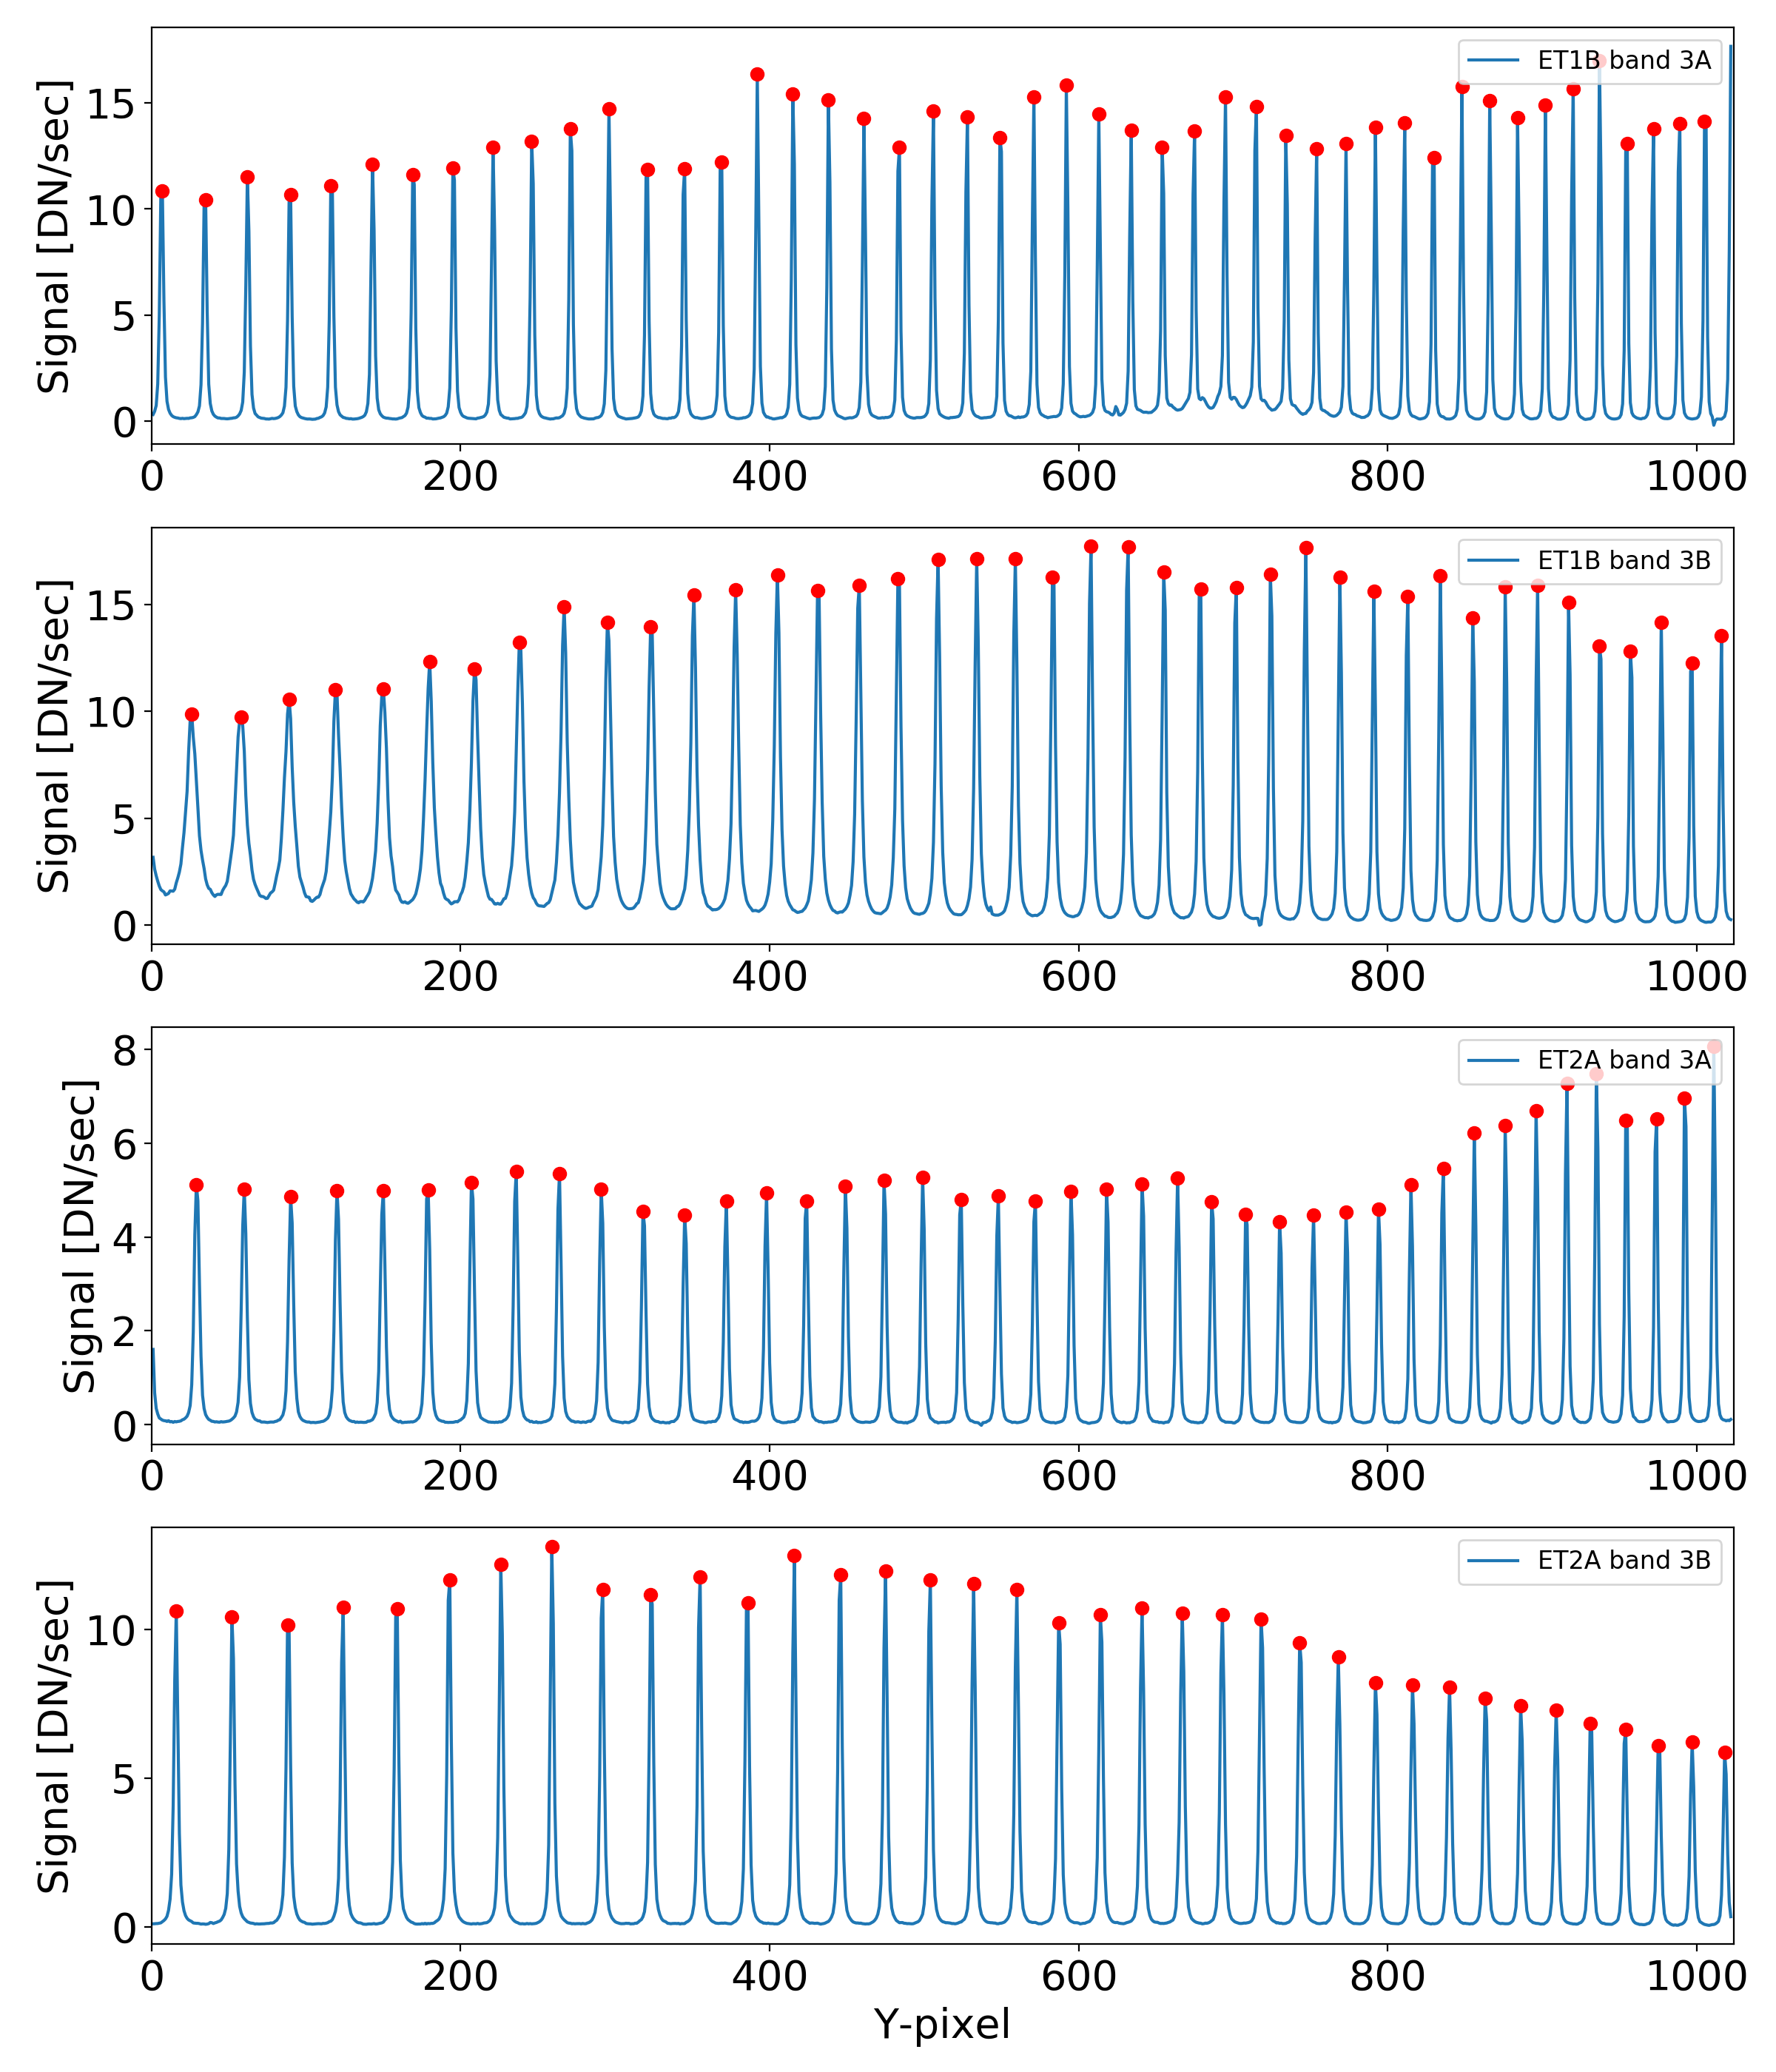

In [12]:
# determine peaks
etalon_data_fm_peaks = {}
for etalon in [ET1,ET2]:
    etalon_data_fm_peaks[etalon] = {}
    if (band1[0] in ['1','2']) & (band2[0] in ['1','2']):
        for band in [band1,band2]:
            if etalon == 'ET1A': thres,min_dist = thres_e1a[band],min_dist_e1a[band]
            elif etalon == 'ET1B': thres,min_dist = thres_e1b[band],min_dist_e1b[band]
            elif etalon == 'ET2A': thres,min_dist = thres_e2a[band],min_dist_e2a[band]
            elif etalon == 'ET2B': thres,min_dist = thres_e2b[band],min_dist_e2b[band]
            etalon_data_fm_peaks[etalon][band] = funcs.find_peaks(etalon_data_fm[etalon][band][ypos,xpos[band]], thres=thres, min_dist=min_dist)
            etalon_data_fm_peaks[etalon][band] = etalon_data_fm_peaks[etalon][band][(etalon_data_fm_peaks[etalon][band]>4) & (etalon_data_fm_peaks[etalon][band]<1020)]

    elif (band1[0] in ['3','4']) & (band2[0] in ['3','4']):
        for band in [band1,band2]:
            if etalon == 'ET1A': thres,min_dist = thres_e1a[band],min_dist_e1a[band]
            elif etalon == 'ET1B': thres,min_dist = thres_e1b[band],min_dist_e1b[band]
            elif etalon == 'ET2A': thres,min_dist = thres_e2a[band],min_dist_e2a[band]
            elif etalon == 'ET2B': thres,min_dist = thres_e2b[band],min_dist_e2b[band]
            etalon_data_fm_peaks[etalon][band] = funcs.find_peaks(etalon_data_fm[etalon][band][ypos,xpos[band]], thres=thres, min_dist=min_dist)
            etalon_data_fm_peaks[etalon][band] = etalon_data_fm_peaks[etalon][band][(etalon_data_fm_peaks[etalon][band]>4) & (etalon_data_fm_peaks[etalon][band]<1020)]
            
fig,axs = plt.subplots(4,1,figsize=(12,14))
axs[0].plot(etalon_data_fm[ET1][band1][ypos,xpos[band1]],label='{} band {}'.format(ET1,band1))
axs[0].plot(etalon_data_fm_peaks[ET1][band1],etalon_data_fm[ET1][band1][ypos,xpos[band1]][etalon_data_fm_peaks[ET1][band1]],'ro')
axs[1].plot(etalon_data_fm[ET1][band2][ypos,xpos[band2]],label='{} band {}'.format(ET1,band2))
axs[1].plot(etalon_data_fm_peaks[ET1][band2],etalon_data_fm[ET1][band2][ypos,xpos[band2]][etalon_data_fm_peaks[ET1][band2]],'ro')
axs[2].plot(etalon_data_fm[ET2][band1][ypos,xpos[band1]],label='{} band {}'.format(ET2,band1))
axs[2].plot(etalon_data_fm_peaks[ET2][band1],etalon_data_fm[ET2][band1][ypos,xpos[band1]][etalon_data_fm_peaks[ET2][band1]],'ro')
axs[3].plot(etalon_data_fm[ET2][band2][ypos,xpos[band2]],label='{} band {}'.format(ET2,band2))
axs[3].plot(etalon_data_fm_peaks[ET2][band2],etalon_data_fm[ET2][band2][ypos,xpos[band2]][etalon_data_fm_peaks[ET2][band2]],'ro')
axs[3].set_xlabel('Y-pixel')
for plot in range(4):
    axs[plot].set_xlim(0,1024)
    axs[plot].set_ylabel('Signal [DN/sec]')
    axs[plot].legend(loc='upper right',fontsize=12)
plt.tight_layout()

In [10]:
# Choose data regions
etalon_fm_data_noNaN = {}
for etalon in [ET1,ET2]:
    etalon_fm_data_noNaN[etalon] = {}
    for band in [band1,band2]:
        etalon_fm_data_noNaN[etalon][band] = etalon_data_fm[etalon][band][ypos,xpos[band]]
        etalon_fm_data_noNaN[etalon][band][np.isnan(etalon_fm_data_noNaN[etalon][band])] = 0.
        
        print("Number of identified etalon lines : {} band {}    [alpha = 0.0]: {} lines".format(etalon,band,len(etalon_data_fm_peaks[etalon][band])))

Number of identified etalon lines : ET1B band 3A    [alpha = 0.0]: 47 lines
Number of identified etalon lines : ET1B band 3B    [alpha = 0.0]: 41 lines
Number of identified etalon lines : ET2A band 3A    [alpha = 0.0]: 42 lines
Number of identified etalon lines : ET2A band 3B    [alpha = 0.0]: 37 lines


<IPython.core.display.Javascript object>


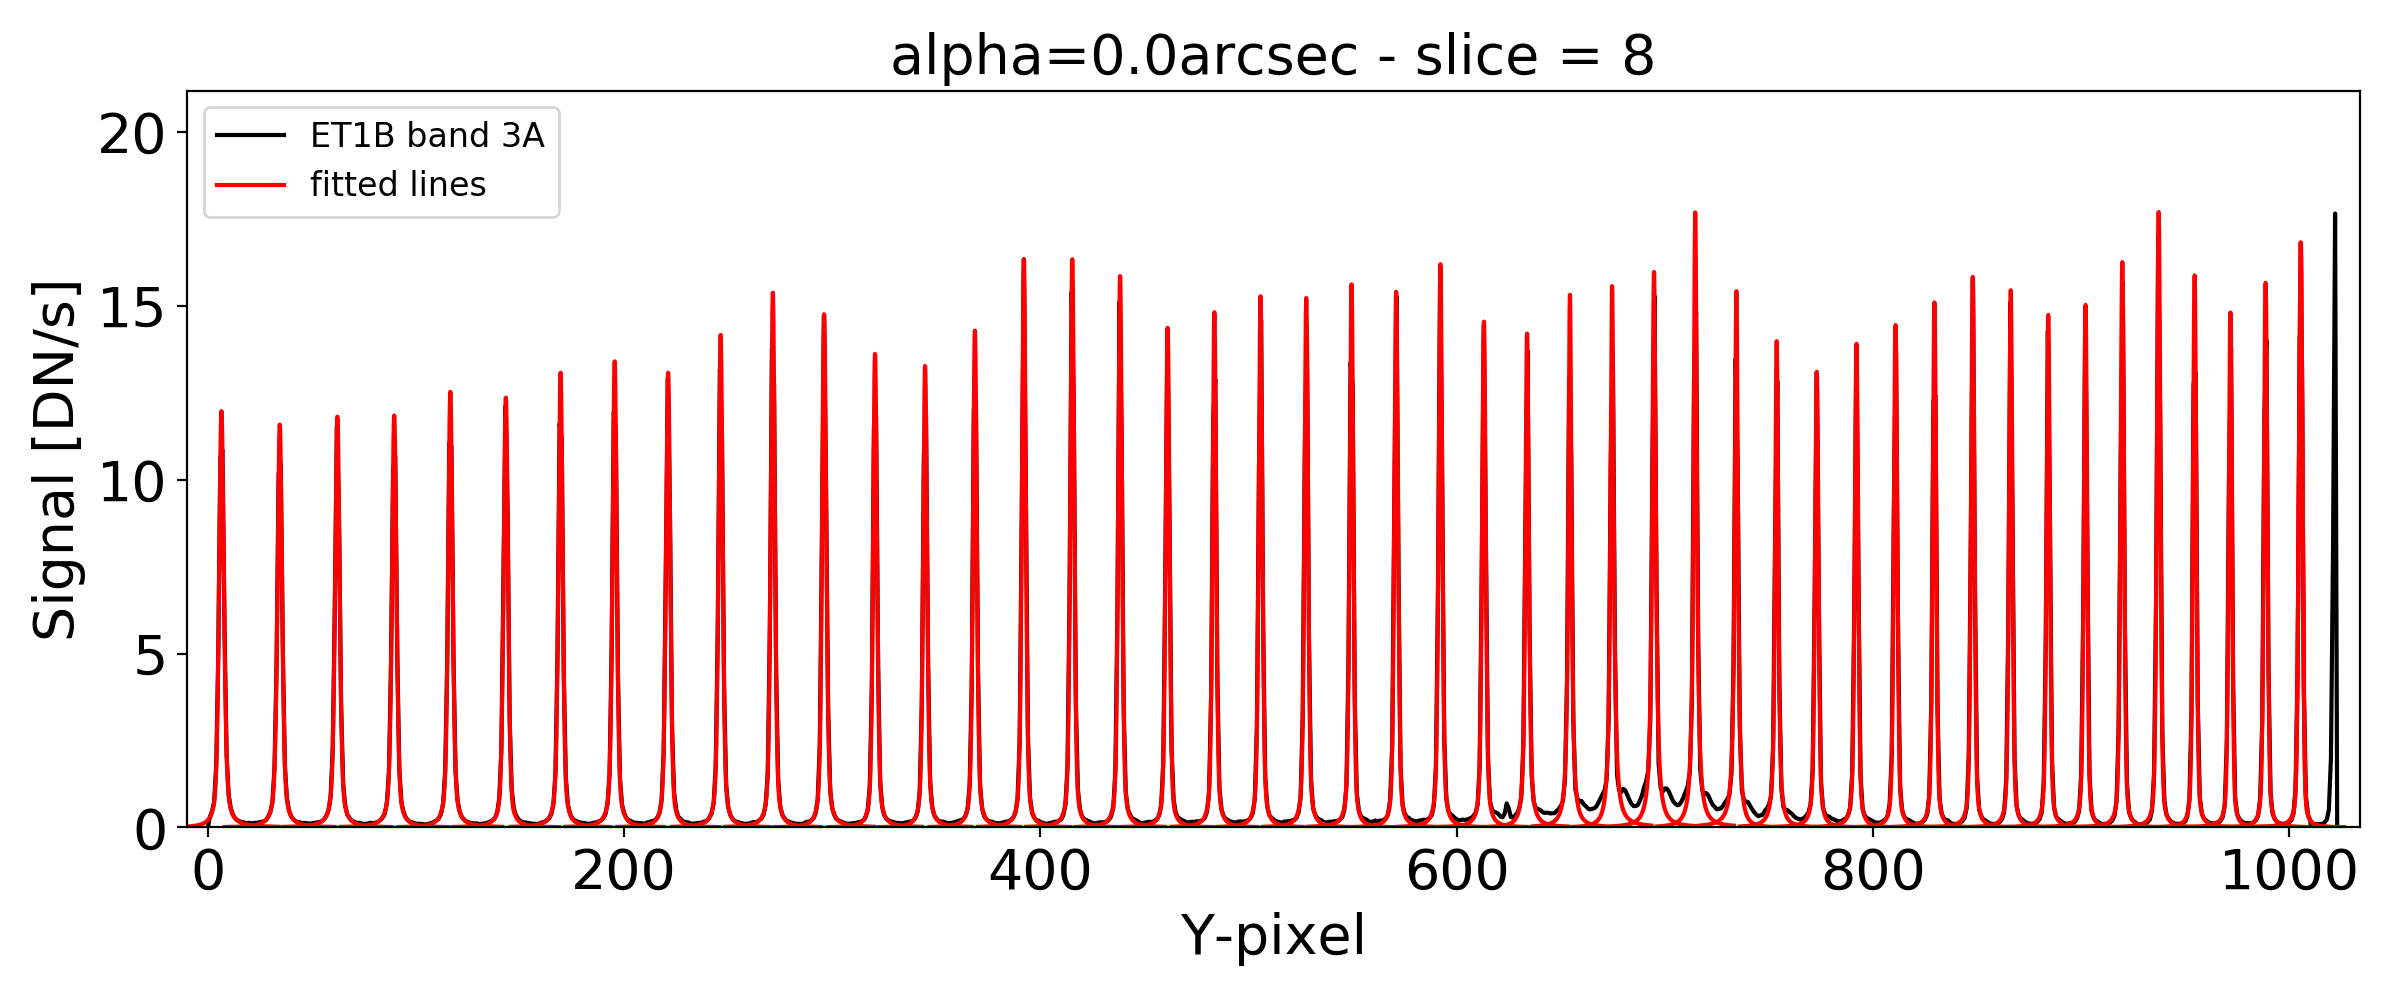

<IPython.core.display.Javascript object>


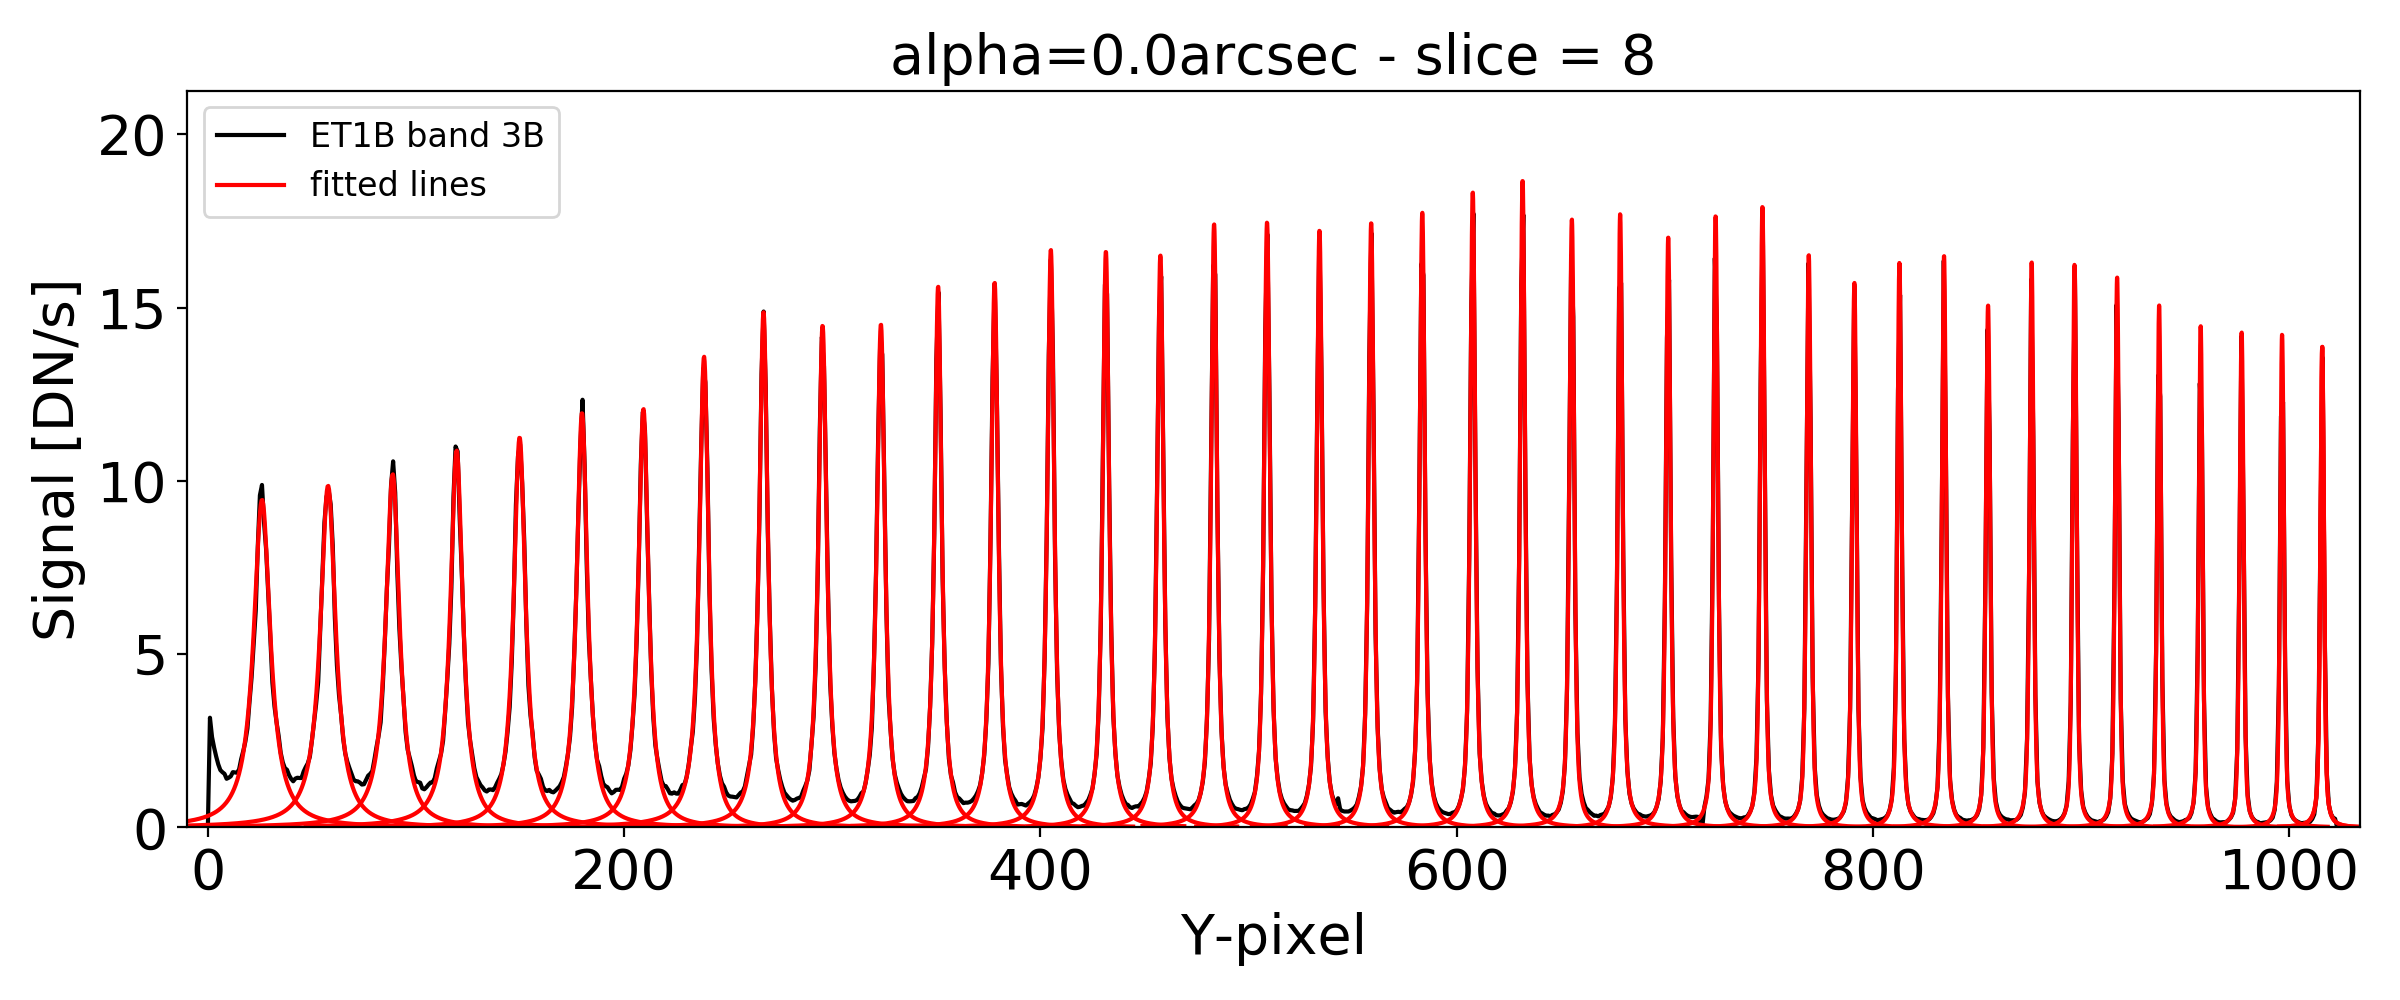

<IPython.core.display.Javascript object>


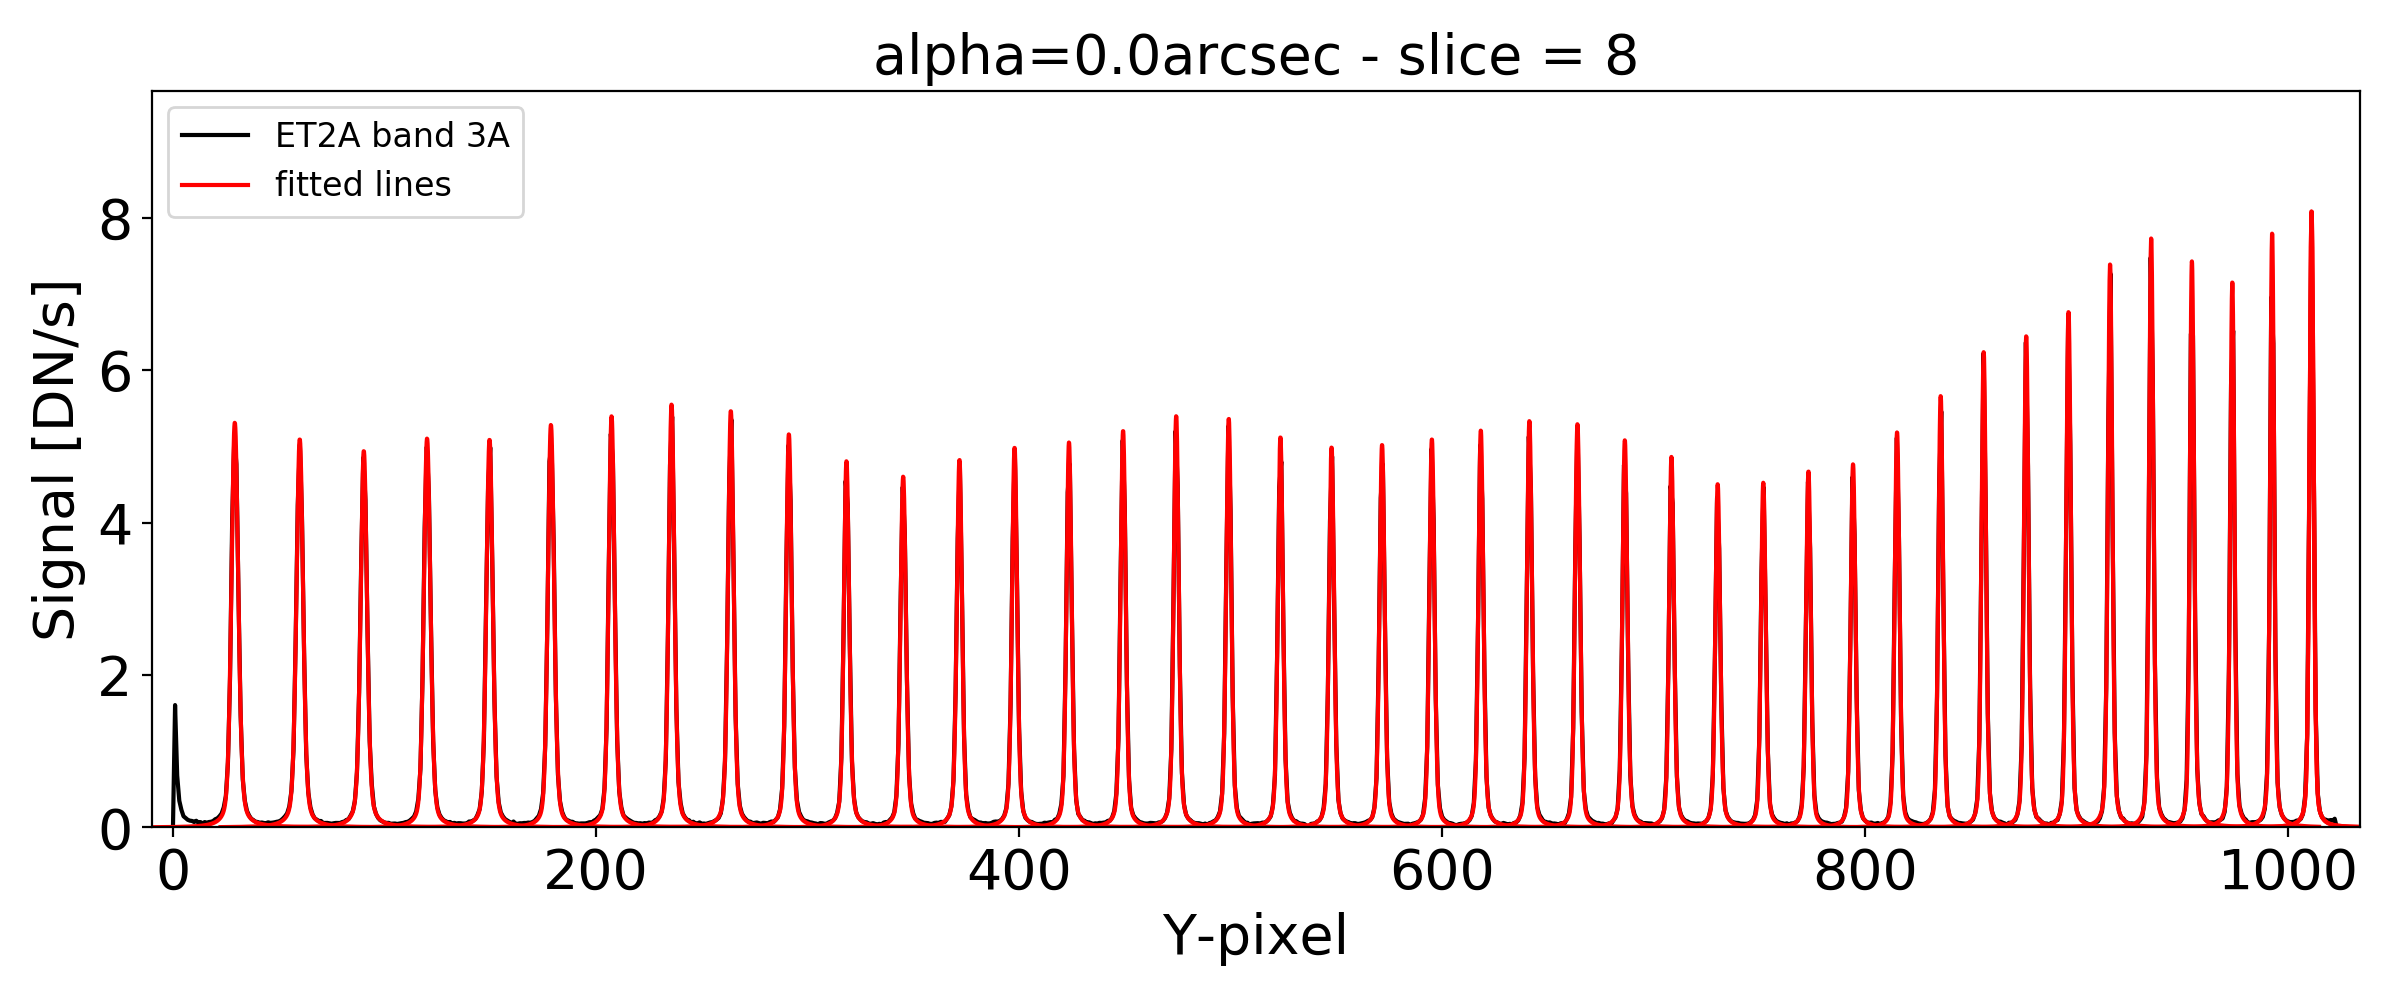

<IPython.core.display.Javascript object>


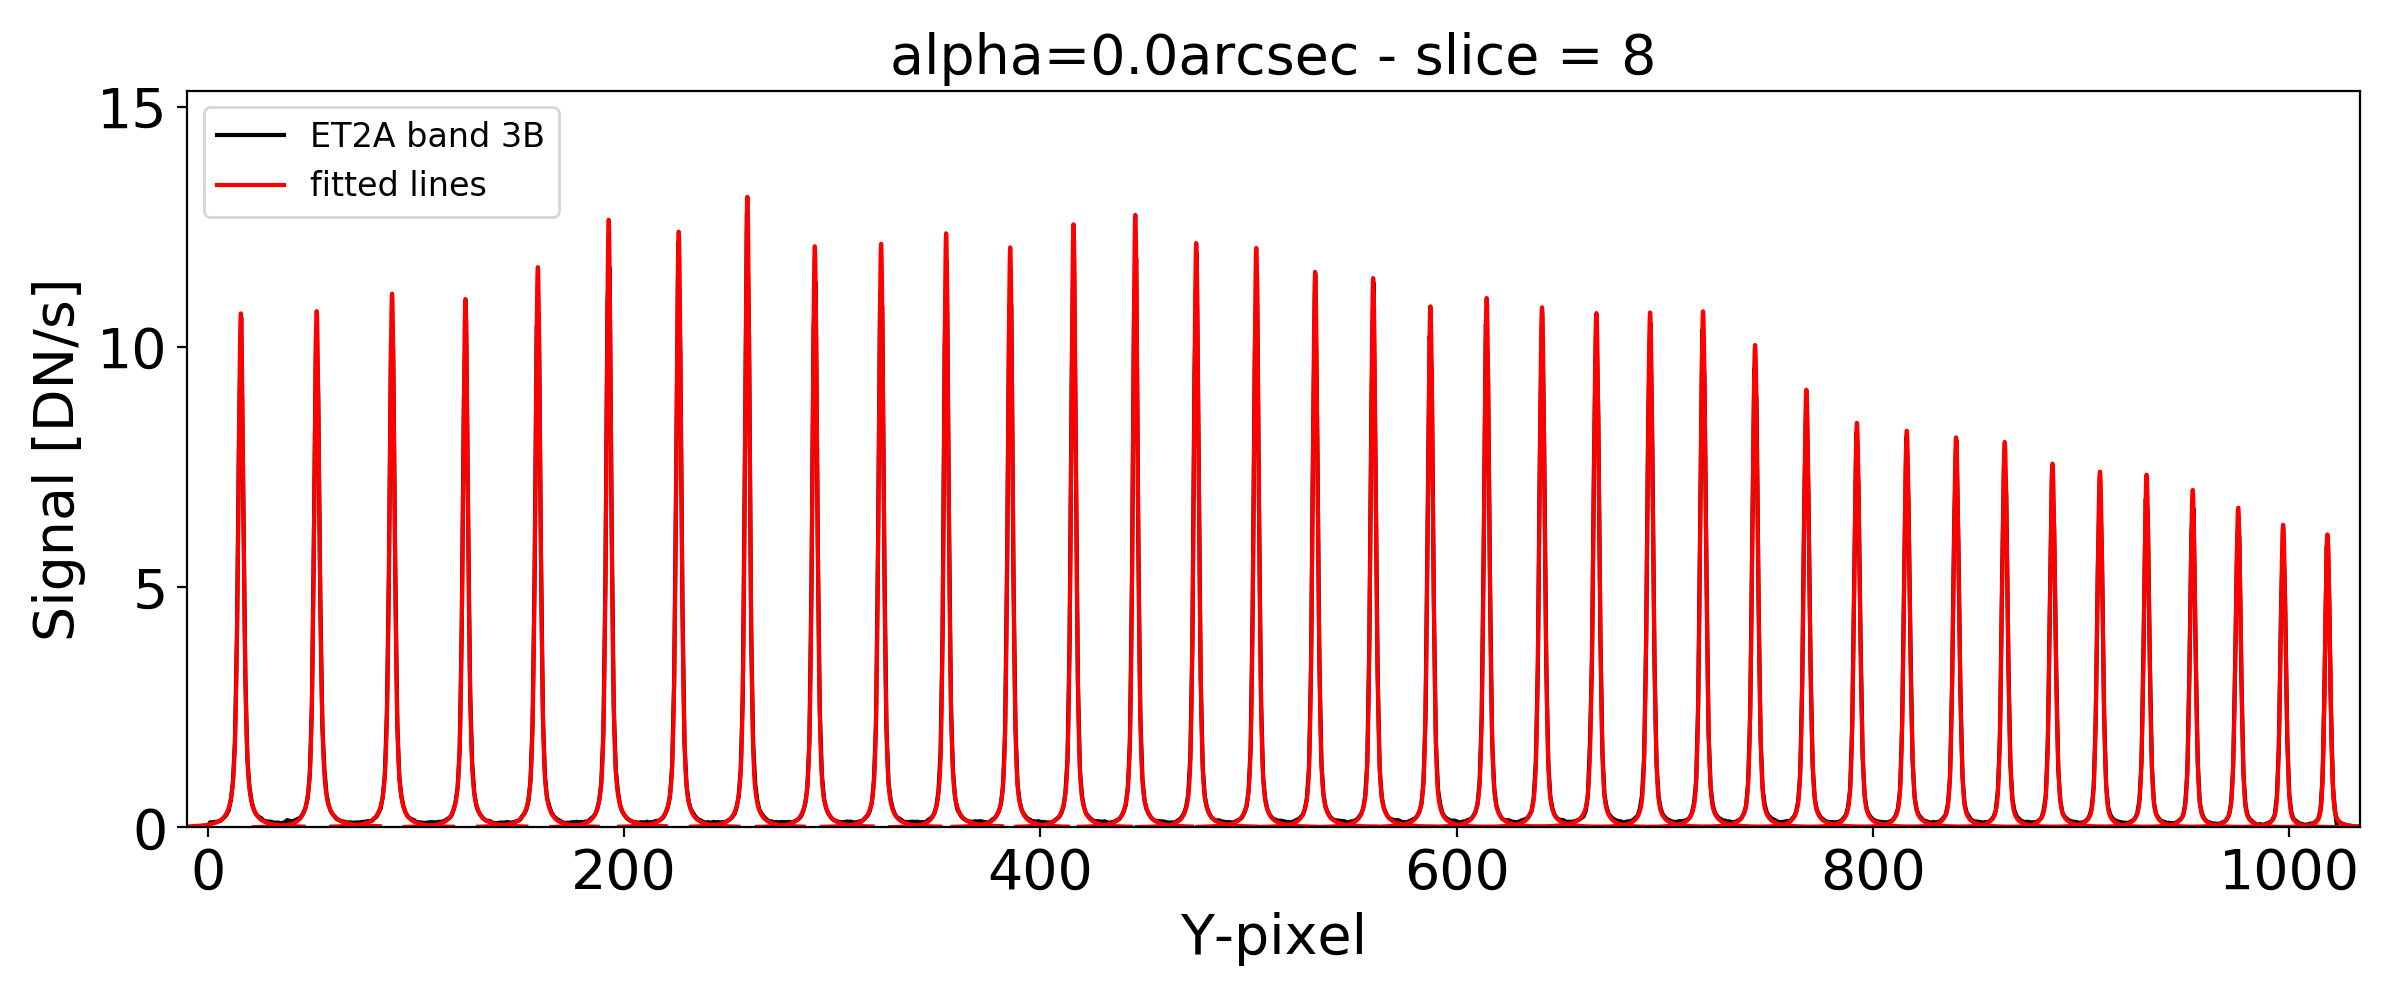

In [11]:
FMetalon_fitparams,fitting_flag,fm_linecenter = {},{},{}
for etalon in [ET1,ET2]:
    FMetalon_fitparams[etalon] = {}
    fitting_flag[etalon] = {}
    fm_linecenter[etalon] = {}
    for band in [band1,band2]:
        if etalon == 'ET1A': sigma = sigma0_e1a[band]
        elif etalon == 'ET1B': sigma = sigma0_e1b[band]
        elif etalon == 'ET2A': sigma = sigma0_e2a[band]
        elif etalon == 'ET2B': sigma = sigma0_e2b[band]
        FMetalon_fitparams[etalon][band],ignore,fitting_flag[etalon][band],ignore,ignore = funcs.fit_etalon_lines(np.arange(len(ypos)),etalon_fm_data_noNaN[etalon][band],etalon_data_fm_peaks[etalon][band],fit_func='skewed_voight',sigma0=sigma,f0=0.5,a0=0.1)
        fm_linecenter[etalon][band] = funcs.get_linecenter(FMetalon_fitparams[etalon][band],fitting_flag[etalon][band])
        
        # Plot the fits
        plt.figure(figsize=(12,5))
        plt.plot(etalon_fm_data_noNaN[etalon][band],'k',label='{} band {}'.format(etalon,band))
        funcs.plot_etalon_fit(FMetalon_fitparams[etalon][band],fitting_flag[etalon][band])
        plt.xlim(-10,1034)
        plt.ylim(0,1.2*max(etalon_fm_data_noNaN[etalon][band]))
        plt.xlabel('Y-pixel',fontsize=20)
        plt.ylabel('Signal [DN/s]',fontsize=20)
        plt.title("alpha={}arcsec - slice = {}".format(str(0.),d2cMaps['nslices']/2))
        plt.tick_params(axis='both',labelsize=20)
        plt.legend(loc='upper left',fontsize=12)
        plt.tight_layout()

<IPython.core.display.Javascript object>


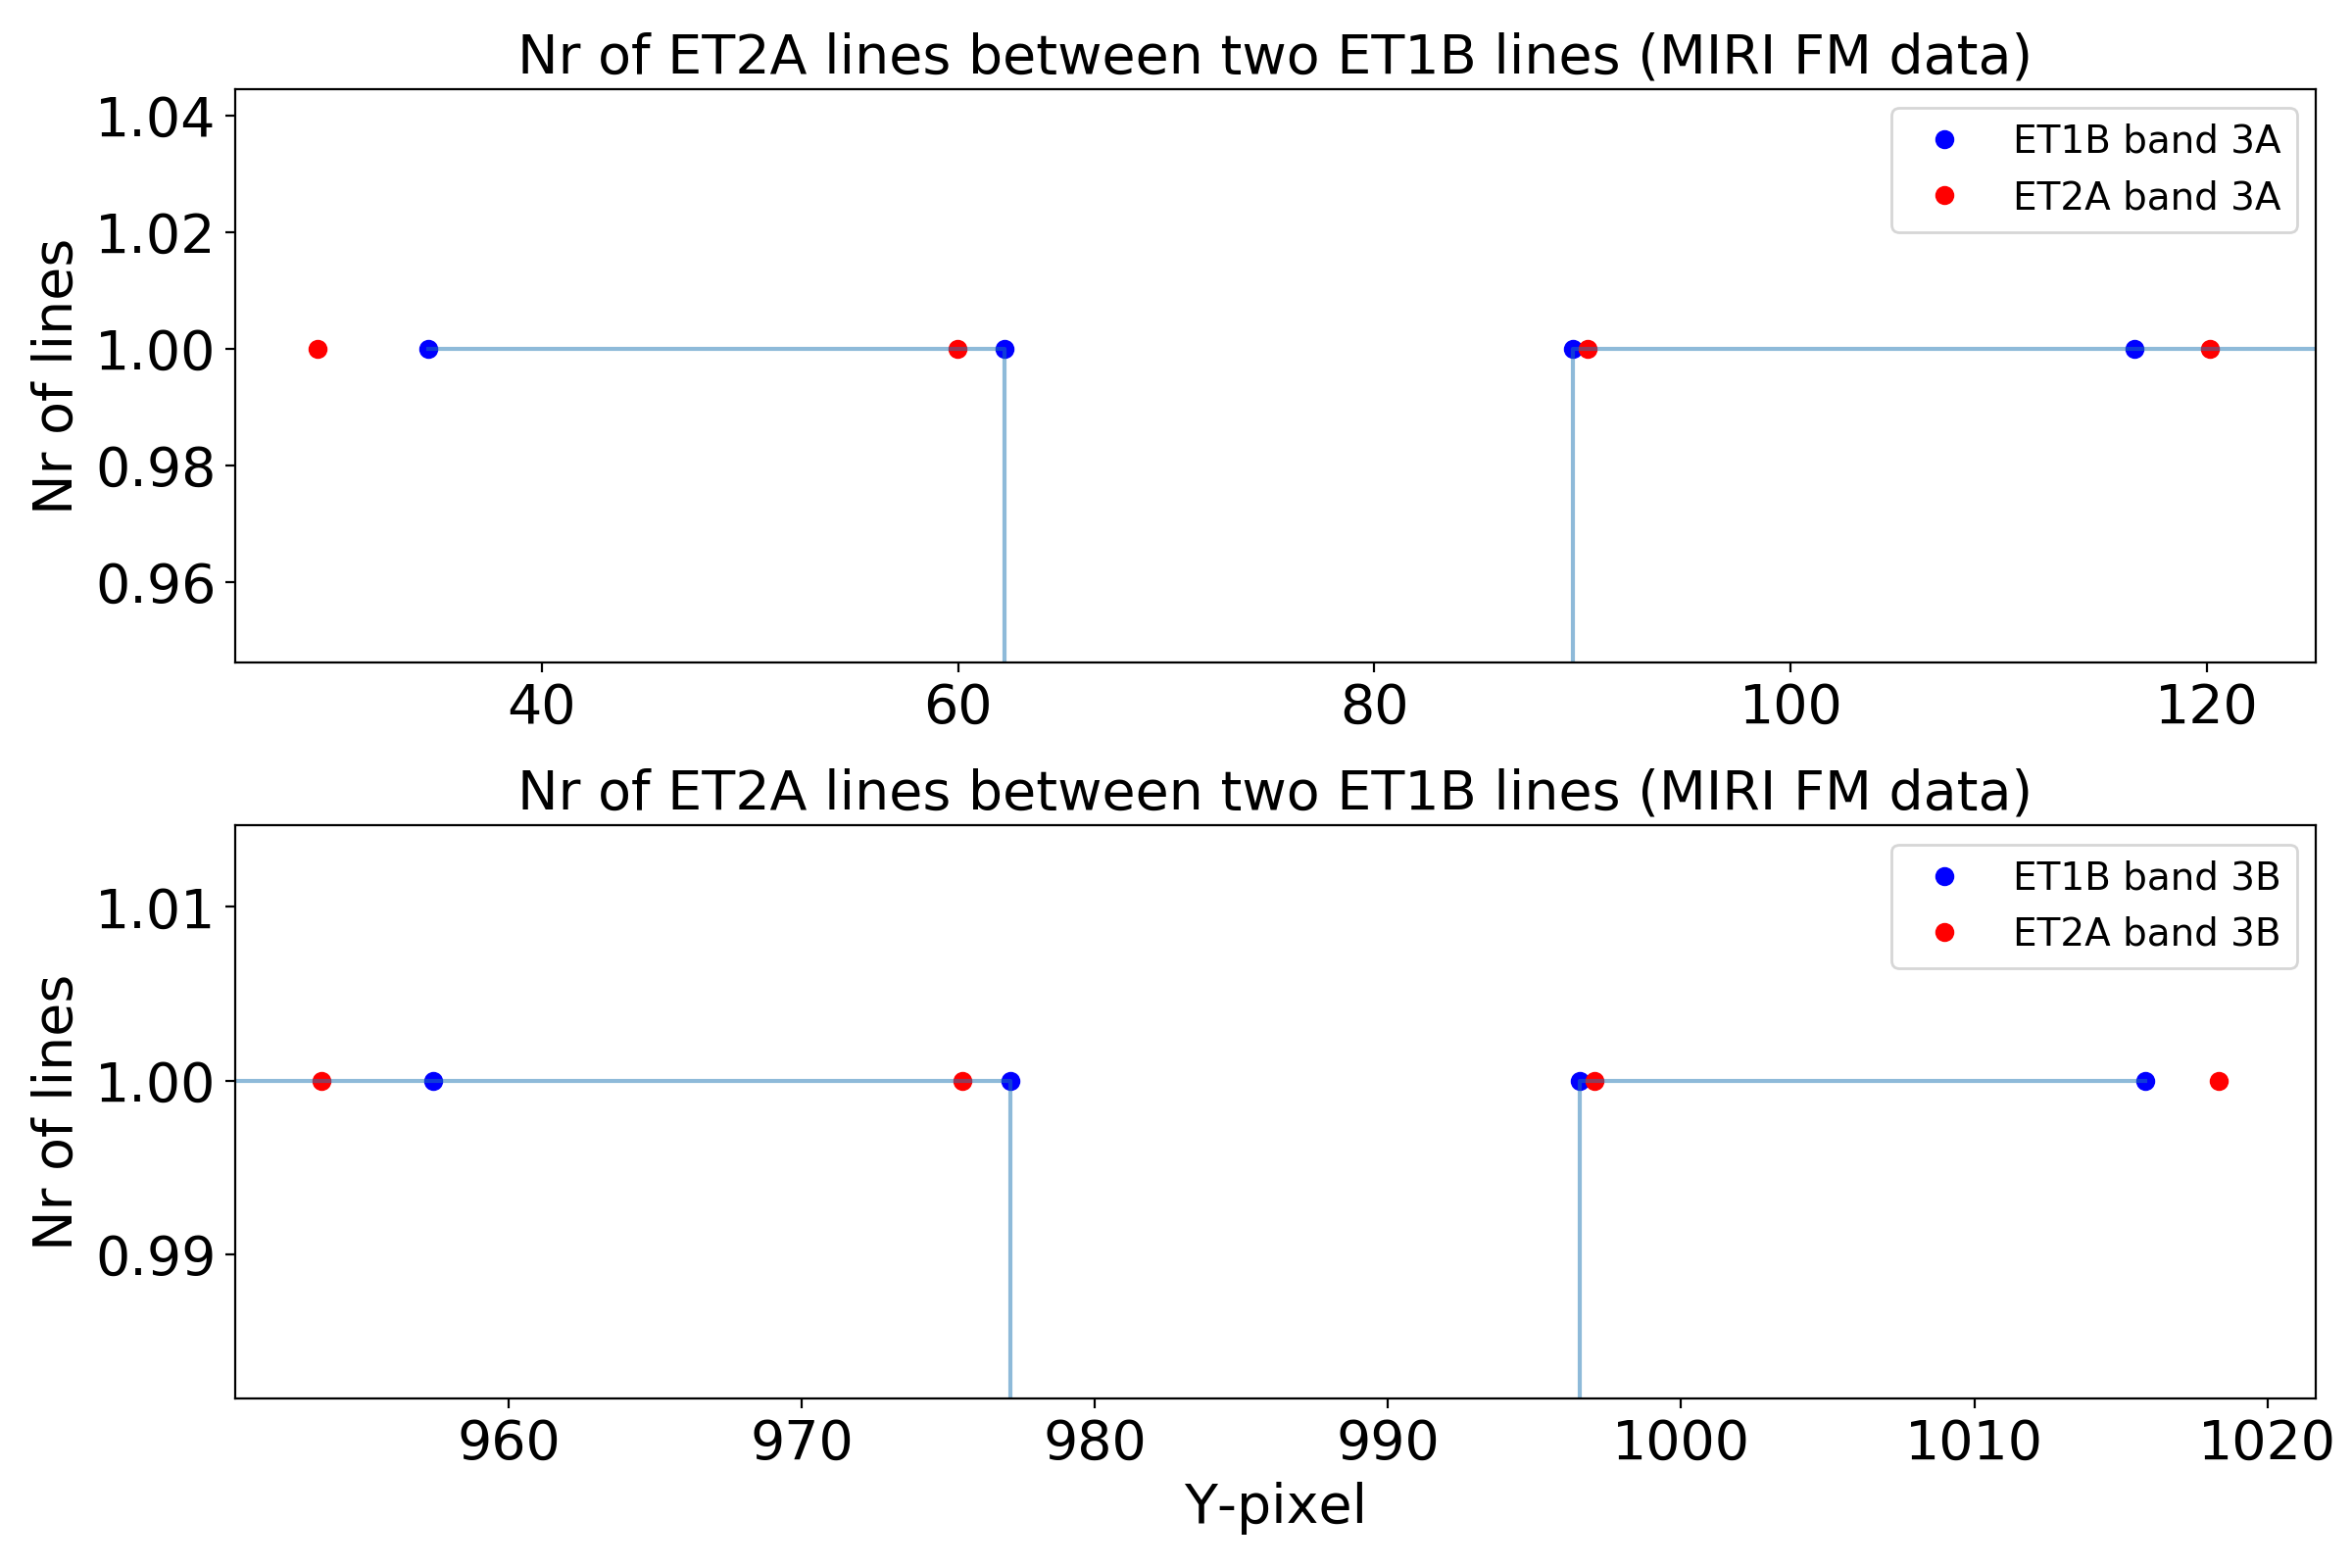

In [17]:
fm_ET1_peaks,fm_ET2_peaks,fm_ET2_ET1_match = {},{},{}
for band in [band1,band2]:
    fm_ET1_peaks[band] = fm_linecenter[ET1][band]
    fm_ET2_peaks[band] = fm_linecenter[ET2][band]

    fm_ET2_ET1_match[band] = np.zeros(len(fm_ET1_peaks[band])-1)
    for i in range(len(fm_ET1_peaks[band])-1):
        fm_ET2_ET1_match[band][i] = len(np.where((fm_ET2_peaks[band]>fm_ET1_peaks[band][i]) & (fm_ET2_peaks[band]<=fm_ET1_peaks[band][i+1]) )[0])
    
fig,axs = plt.subplots(2,1,figsize=(12,8))
axs[0].plot(fm_ET1_peaks[band1],np.ones(len(fm_ET1_peaks[band1])),'bo',label='{} band {}'.format(ET1,band1))
axs[0].plot(fm_ET2_peaks[band1],np.ones(len(fm_ET2_peaks[band1])),'ro',label='{} band {}'.format(ET2,band1))
axs[0].step(fm_ET1_peaks[band1][1:],fm_ET2_ET1_match[band1],alpha=0.5)
axs[1].plot(fm_ET1_peaks[band2],np.ones(len(fm_ET1_peaks[band2])),'bo',label='{} band {}'.format(ET1,band2))
axs[1].plot(fm_ET2_peaks[band2],np.ones(len(fm_ET2_peaks[band2])),'ro',label='{} band {}'.format(ET2,band2))
axs[1].step(fm_ET1_peaks[band2][1:],fm_ET2_ET1_match[band2],alpha=0.5)
for plot in range(2):
    axs[plot].set_xlim(0)
    axs[plot].set_ylim(0.9,1.1)
    axs[plot].set_ylabel('Nr of lines')
    axs[plot].set_title('Nr of {} lines between two {} lines (MIRI FM data)'.format(ET2,ET1))
    axs[plot].legend(loc='upper right')
axs[1].set_xlabel('Y-pixel')
plt.tight_layout()

In [18]:
if (band1[0] in ['3','4']) & (band2[0] in ['3','4']):
    print '{} in band {} has an etalon line centered at {}pix that matches the etalon line of {} in band {} at {}pix'.format(ET1,band1,round(fm_ET1_peaks[band1][np.where(fm_ET2_ET1_match[band1] ==0)[0][0]+1],3),ET1,band2,round(fm_ET1_peaks[band2][np.where(fm_ET2_ET1_match[band2] ==0)[0][-1]+1],3) )
    print '{} in band {} has an etalon line centered at {}pix that matches the etalon line of {} in band {} at {}pix'.format(ET2,band1,round(fm_ET2_peaks[band1][funcs.find_nearest(fm_ET2_peaks[band1],fm_ET1_peaks[band1][np.where(fm_ET2_ET1_match[band1] ==0)[0][0]+1])],3),ET2,band2,round(fm_ET2_peaks[band2][funcs.find_nearest(fm_ET2_peaks[band2],fm_ET1_peaks[band2][np.where(fm_ET2_ET1_match[band2] ==0)[0][-1]+1])],3) )
    
    # save results
    d2cMaps   = d2cMapping(start_band,cdpDir,fileversion='8B.05.00')
    lambdaMap = d2cMaps['lambdaMap']
    ilambda   = interp1d(ypos,lambdaMap[ypos,xpos[start_band]])
    cutofflamb_ET1 = ilambda(fm_ET1_peaks[band1][np.where(fm_ET2_ET1_match[start_band] ==0)[0][0]])
    cutoffpix_ET1  = fm_ET1_peaks[band2][np.where(fm_ET2_ET1_match[band2] ==0)[0][-1]]
    
    print ''
    print '({}) cut-off wavelength: {} micron'.format(ET1,round(cutofflamb_ET1,5))
    print '({}) cut-off pixel: {} pix'.format(ET1,round(cutoffpix_ET1,3))
    
    cutofflamb_ET2 = ilambda(fm_ET2_peaks[band1][funcs.find_nearest(fm_ET2_peaks[band1],fm_ET1_peaks[band1][np.where(fm_ET2_ET1_match[band1] ==0)[0][0]])])
    cutoffpix_ET2  = fm_ET2_peaks[band2][funcs.find_nearest(fm_ET2_peaks[band2],fm_ET1_peaks[band2][np.where(fm_ET2_ET1_match[band2] ==0)[0][-1]])]
    
    print ''
    print '({}) cut-off wavelength: {} micron'.format(ET2,round(cutofflamb_ET2,5))
    print '({}) cut-off pixel: {} pix'.format(ET2,round(cutoffpix_ET2,3))

ET1B in band 3A has an etalon line centered at 89.537pix that matches the etalon line of ET1B in band 3B at 996.527pix
ET2A in band 3A has an etalon line centered at 90.229pix that matches the etalon line of ET2A in band 3B at 997.04pix

(ET1B) cut-off wavelength: 13.37811 micron
(ET1B) cut-off pixel: 977.106 pix

(ET2A) cut-off wavelength: 13.38221 micron
(ET2A) cut-off pixel: 975.469 pix


In [39]:
# save output
# etalon 1
save_file = open('data/BandOverlapWaveCal_Band{}_{}_refslice'.format(target_band,ET1)+str(refslice)+'_alpha'+str(alpha_pos)+'.txt', 'w')
save_file.write('# Band '+str(target_band)+'   Etalon {}   RefSlice '.format(ET1)+str(refslice)+'\n')
save_file.write('# Distortion map version {}'+d2c_fileversion+' - date '+str(date.today())+'\n')
save_file.write('# Trace (isoalpha): Take pixel trace along specified slice, specified alpha position trace is built by taking the pixel in every detector row with alpha value closest to the one specified \n')
save_file.write('# xpos[i] = np.argmin(alpha_img[i,:])+funcs.find_nearest(alpha_img[i,:][(slice_img[i,:]!=0)],alpha_pos)\n')
save_file.write('# Band'+str(target_band)+'_{}_refslice'.format(ET1)+str(refslice)+'_alpha'+str(alpha_pos)+'\n')
save_file.write('\n')
save_file.write('# Reference Wavelength  Reference pixel (pix)\n')

save_file.write(str(cutofflamb_ET1)+'  '+str(cutoffpix_ET1))
save_file.close()

# etalon 2
save_file = open('data/BandOverlapWaveCal_Band{}_{}_refslice'.format(target_band,ET2)+str(refslice)+'_alpha'+str(alpha_pos)+'.txt', 'w')
save_file.write('# Band '+str(target_band)+'   Etalon {}   RefSlice '.format(ET2)+str(refslice)+'\n')
save_file.write('# Distortion map version {}'+d2c_fileversion+' - date '+str(date.today())+'\n')
save_file.write('# Trace (isoalpha): Take pixel trace along specified slice, specified alpha position trace is built by taking the pixel in every detector row with alpha value closest to the one specified \n')
save_file.write('# xpos[i] = np.argmin(alpha_img[i,:])+funcs.find_nearest(alpha_img[i,:][(slice_img[i,:]!=0)],alpha_pos)\n')
save_file.write('# Band'+str(target_band)+'_{}_refslice'.format(ET2)+str(refslice)+'_alpha'+str(alpha_pos)+'\n')
save_file.write('\n')
save_file.write('# Reference Wavelength  Reference pixel (pix)\n')

save_file.write(str(cutofflamb_ET2)+'  '+str(cutoffpix_ET2))
save_file.close()

In [11]:
# band 1A to 1B: 939.526, 52.8159
# band 1C to 2A: 937.4,90.754

### Cross-check result with the latest CDP wavelength solution

In [41]:
from distortionMaps import d2cMapping

lambdaMap = {}
for band in [band1,band2]:
    d2cMaps = d2cMapping(band,cdpDir,fileversion='8B.05.00')
#     d2cMaps  = d2cMapping(band,cdpDir)
    lambdaMap[band] = d2cMaps['lambdaMap']

In [42]:
# print interp1d(np.arange(1024),lambdaMap['1C'][ypos,xpos['1C']])(928.892)
# print interp1d(np.arange(1024),lambdaMap['2A'][ypos,xpos['2A']])(84.3438)

print interp1d(np.arange(1024),lambdaMap[band1][ypos,xpos[band1]])(132.888)
print interp1d(np.arange(1024),lambdaMap[band2][ypos,xpos[band2]])(973.436)

17.793862808939995
17.76282347684049


<IPython.core.display.Javascript object>


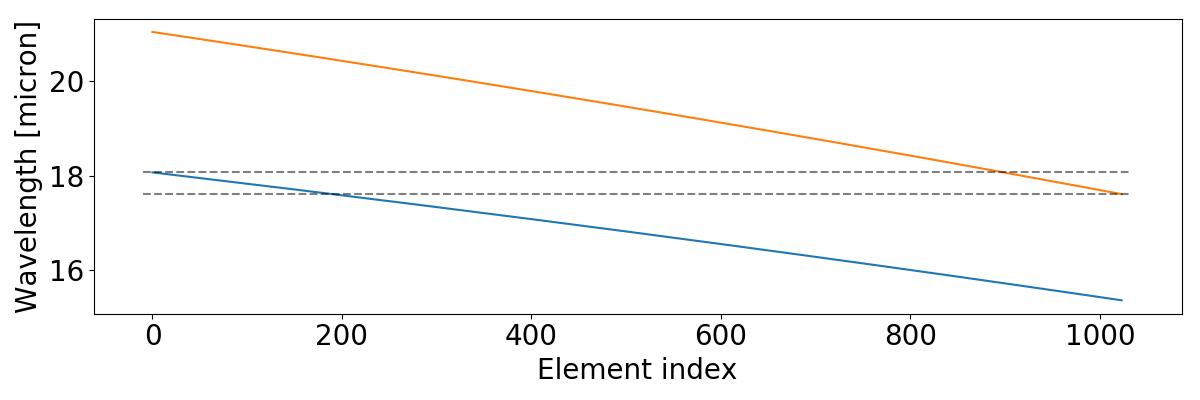

Target wavelength in band 1: 18.0699 micron
Nearby wavelengths in band 2: 18.068, 18.0716, 18.0753 micron
Closest pixel, in band 2: 898 

Target wavelength in band 2: 17.6097 micron
Nearby wavelengths in band 1: 17.6084, 17.6109, 17.6134 micron
Closest pixel, in band 2: 190 



In [16]:
plt.figure(figsize=(12,4))
for band in [band1,band2]:
    plt.plot(lambdaMap[band][ypos,xpos[band]],zorder=0)
if (band1[0] in ['1','2']) & (band2[0] in ['1','2']):
    plt.hlines([lambdaMap[band2][ypos,xpos[band2]][0],lambdaMap[band1][ypos,xpos[band1]][-1]],-10,1034,alpha=0.5,linestyle='dashed',zorder=1)
elif (band1[0] in ['3','4']) & (band2[0] in ['3','4']):
    plt.hlines([lambdaMap[band2][ypos,xpos[band2]][-1],lambdaMap[band1][ypos,xpos[band1]][0]],-10,1034,alpha=0.5,linestyle='dashed',zorder=1)
plt.xlabel('Element index')
plt.ylabel('Wavelength [micron]')
plt.tight_layout()

# from band 1 to band 2 ==>
if (band1[0] in ['1','2']) & (band2[0] in ['1','2']):
    closest_pixel = funcs.find_nearest(lambdaMap[band2][ypos,xpos[band2]],lambdaMap[band1][ypos,xpos[band1]][-1])
    print 'Target wavelength in band 1: {} micron'.format(round(lambdaMap[band1][ypos,xpos[band1]][-1],4))
    print 'Nearby wavelengths in band 2: {}, {}, {} micron'.format(round(lambdaMap[band2][ypos,xpos[band2]][closest_pixel-1],4),round(lambdaMap[band2][ypos,xpos[band2]][closest_pixel],4),round(lambdaMap[band2][ypos,xpos[band2]][closest_pixel+1],4))
elif (band1[0] in ['3','4']) & (band2[0] in ['3','4']):
    closest_pixel = funcs.find_nearest(lambdaMap[band2][ypos,xpos[band2]],lambdaMap[band1][ypos,xpos[band1]][0])
    print 'Target wavelength in band 1: {} micron'.format(round(lambdaMap[band1][ypos,xpos[band1]][0],4))
    print 'Nearby wavelengths in band 2: {}, {}, {} micron'.format(round(lambdaMap[band2][ypos,xpos[band2]][closest_pixel+1],4),round(lambdaMap[band2][ypos,xpos[band2]][closest_pixel],4),round(lambdaMap[band2][ypos,xpos[band2]][closest_pixel-1],4))
print 'Closest pixel, in band 2: {} \n'.format(closest_pixel)

# from band 2 to band 1 ==>
if (band1[0] in ['1','2']) & (band2[0] in ['1','2']):
    closest_pixel = funcs.find_nearest(lambdaMap[band1][ypos,xpos[band1]],lambdaMap[band2][ypos,xpos[band2]][0])
    print 'Target wavelength in band 1: {} micron'.format(round(lambdaMap[band1][ypos,xpos[band1]][0],4))
    print 'Nearby wavelengths in band 1: {}, {}, {} micron'.format(round(lambdaMap[band1][ypos,xpos[band1]][closest_pixel-1],4),round(lambdaMap[band1][ypos,xpos[band1]][closest_pixel],4),round(lambdaMap[band1][ypos,xpos[band1]][closest_pixel+1],4))
elif (band1[0] in ['3','4']) & (band2[0] in ['3','4']):
    closest_pixel = funcs.find_nearest(lambdaMap[band1][ypos,xpos[band1]],lambdaMap[band2][ypos,xpos[band2]][-1])
    print 'Target wavelength in band 2: {} micron'.format(round(lambdaMap[band2][ypos,xpos[band2]][-1],4))
    print 'Nearby wavelengths in band 1: {}, {}, {} micron'.format(round(lambdaMap[band1][ypos,xpos[band1]][closest_pixel+1],4),round(lambdaMap[band1][ypos,xpos[band1]][closest_pixel],4),round(lambdaMap[band1][ypos,xpos[band1]][closest_pixel-1],4))
print 'Closest pixel, in band 2: {} \n'.format(closest_pixel)
